### Project Setup

In [2383]:
!pip install seaborn
!pip install scipy
!pip install scikit-learn

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


### Citirea setului de date

In [2384]:
# Citirea setului de date
df = pd.read_csv('dataset.csv')

### Filtrarea datelor

In [2385]:
# Eliminam din dataset NaN si +- Inifity
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [2386]:
# Inlocuiesc NaN si +- Infinity cu mediana pe coloane pentru
#df = df.replace([np.inf, -np.inf], np.nan)
#df = df.apply(lambda x: x.fillna(x.median()), axis=0)

# 3.1. Explorarea Datelor (Exploratory Data Analysis)

## 1. Analiza Echilibrului de Clase

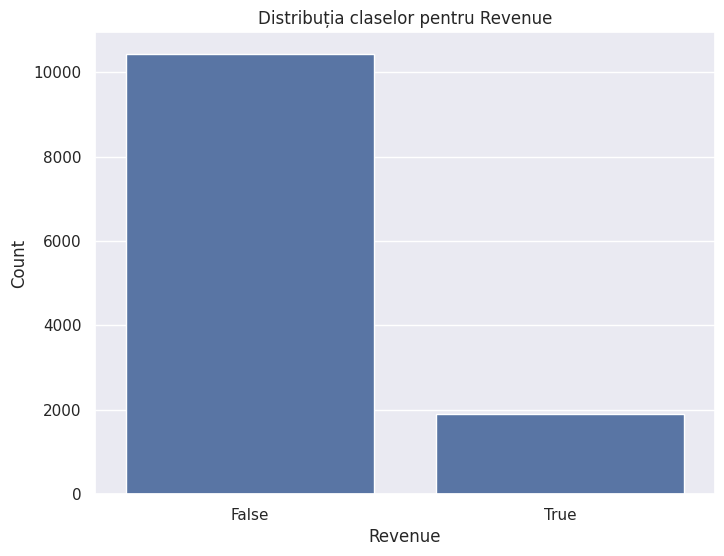

In [2387]:
# Verificarea echilibrului claselor
plt.figure(figsize=(8, 6))
sns.countplot(x='Revenue', data=df)
plt.title('Distribuția claselor pentru Revenue')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.show()

## 2. Vizualizarea Atributelor

### 2.A Atribute Numerice

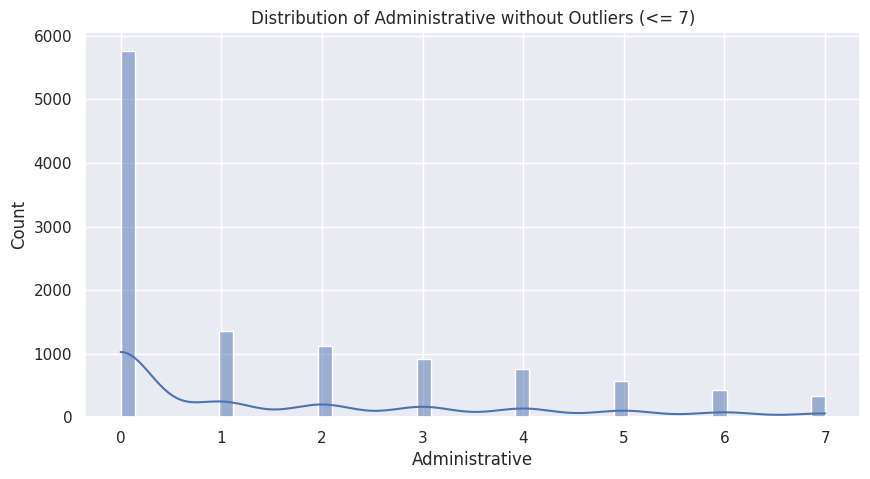

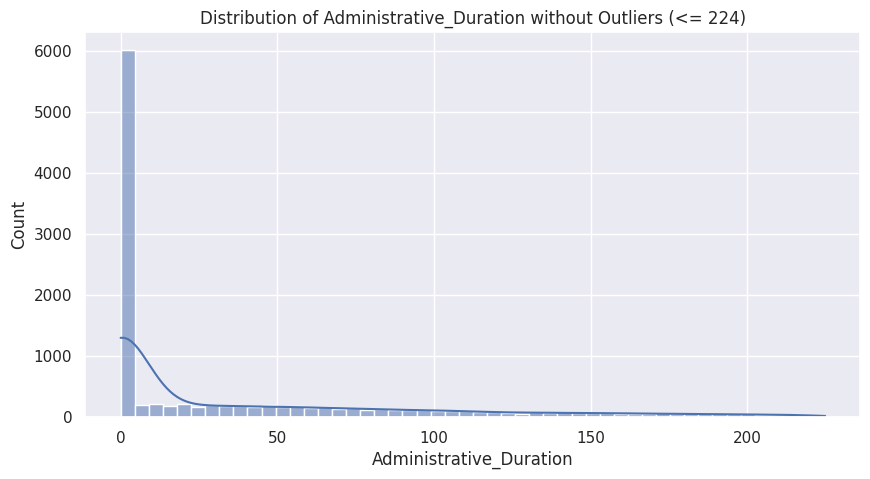

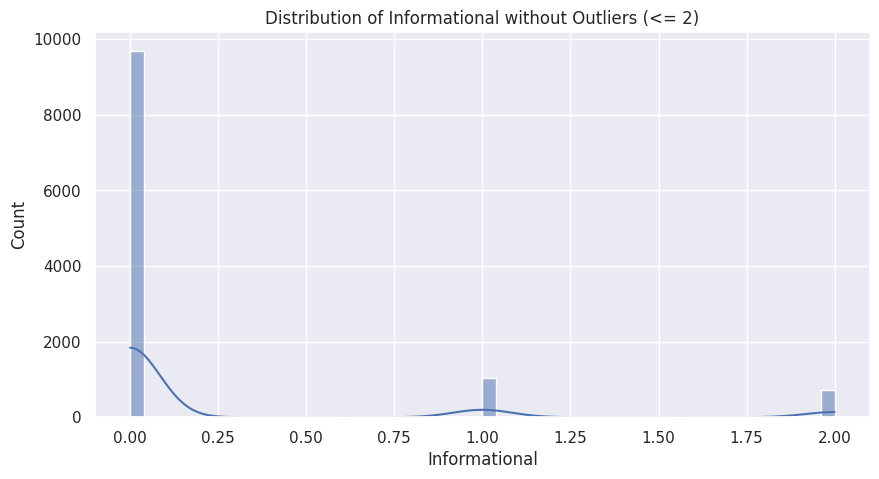

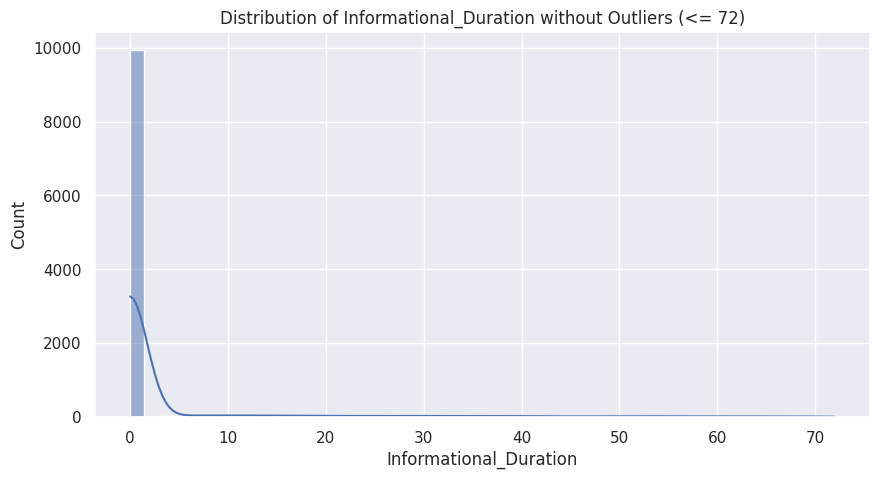

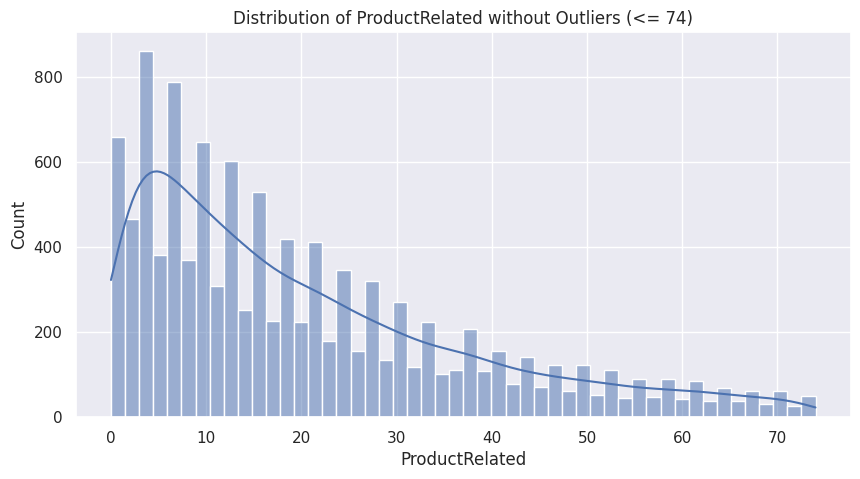

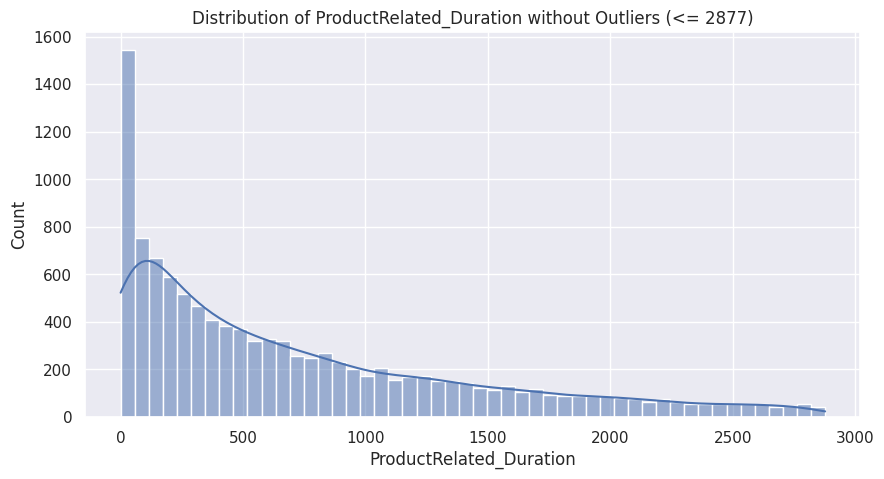

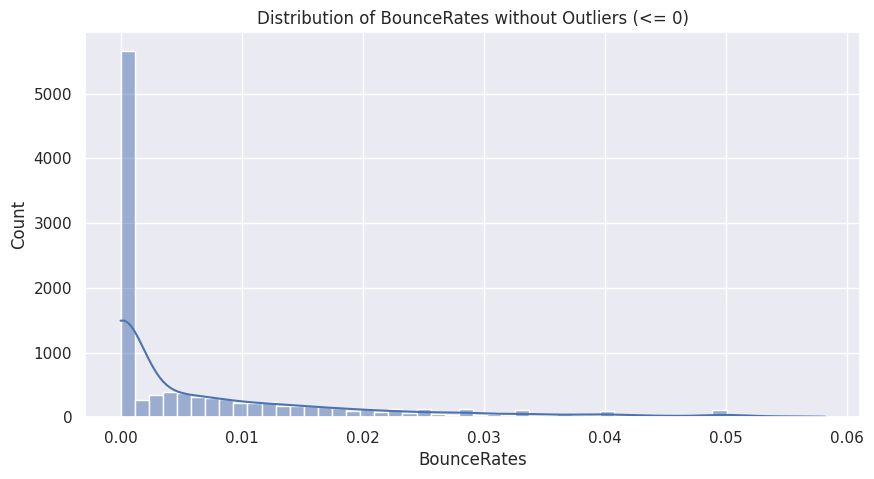

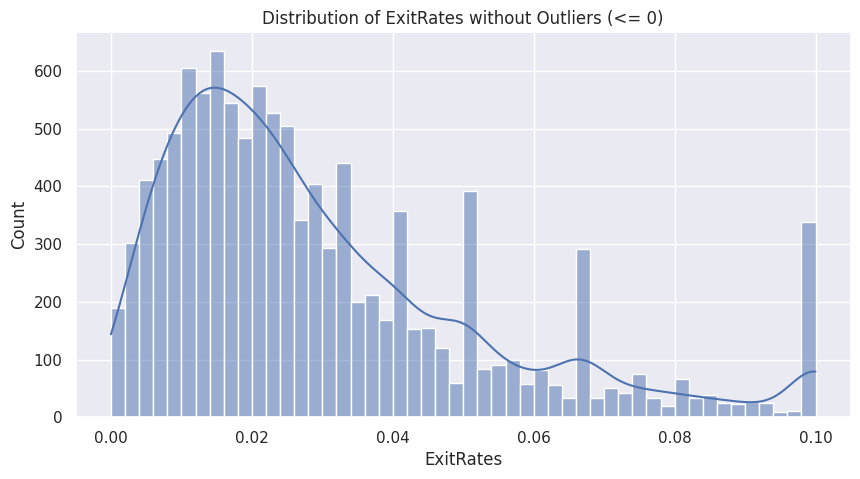

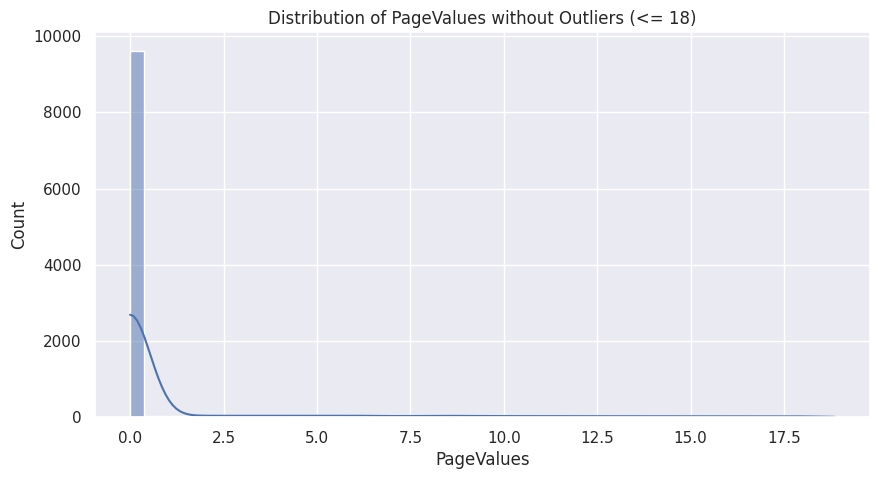

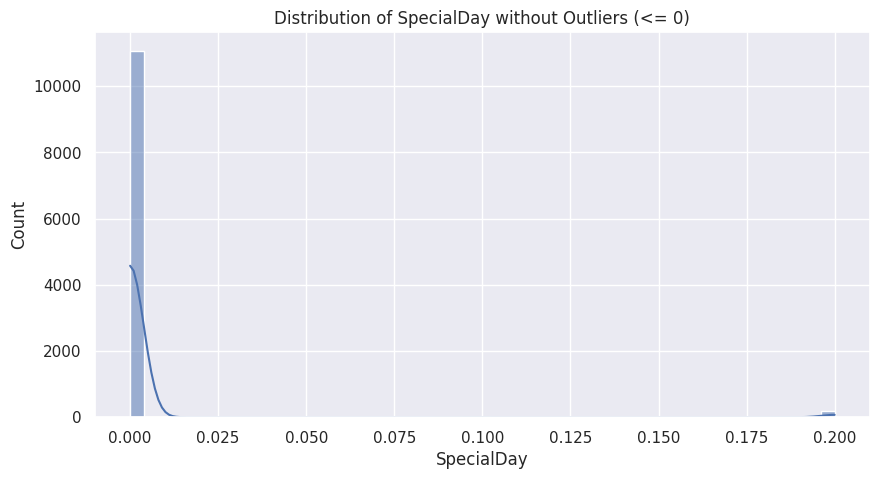

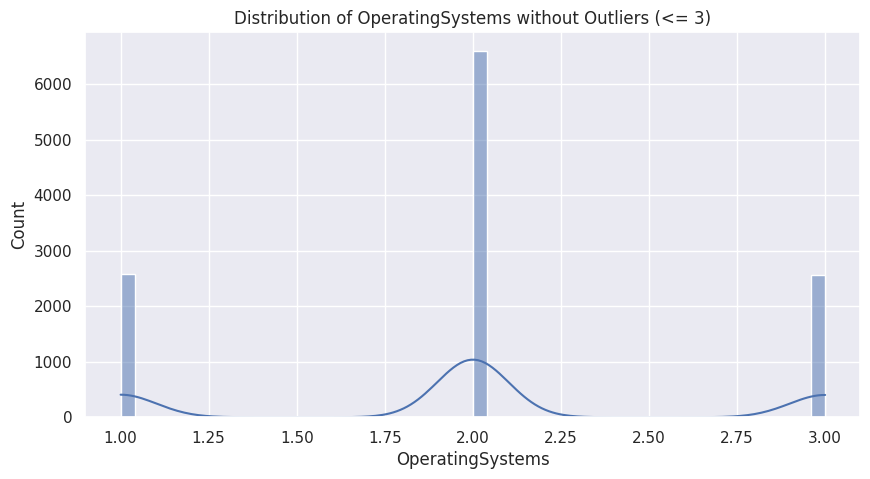

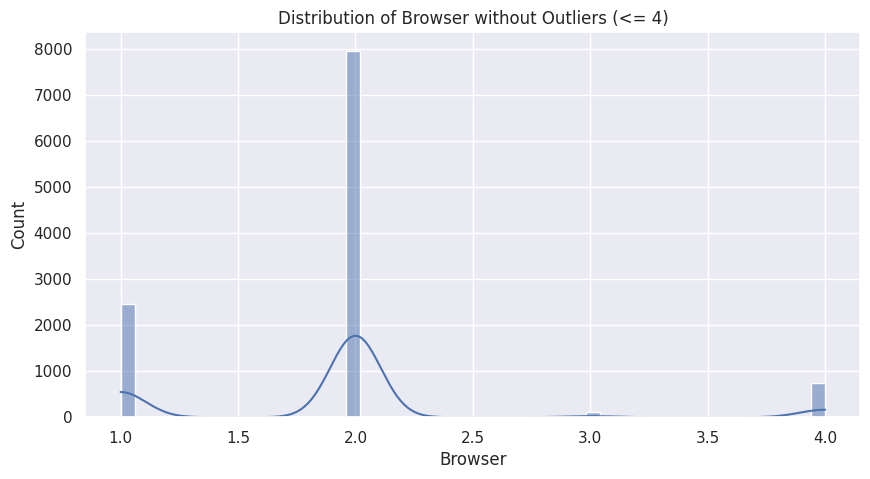

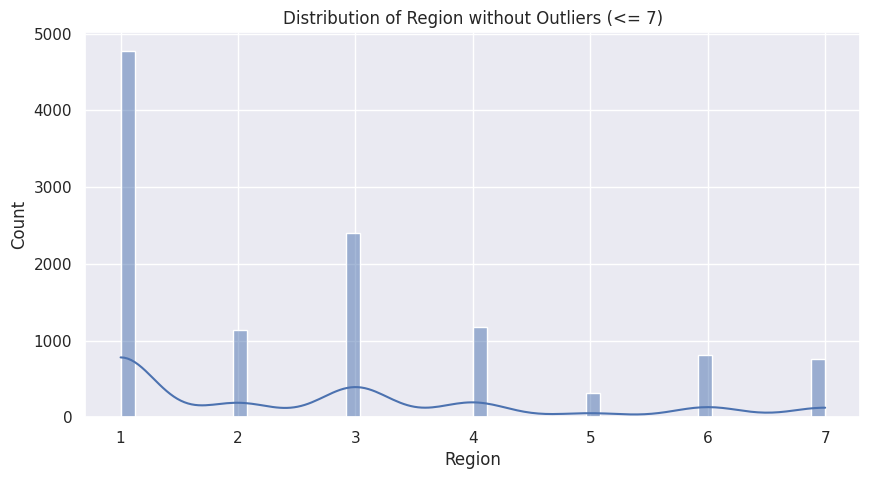

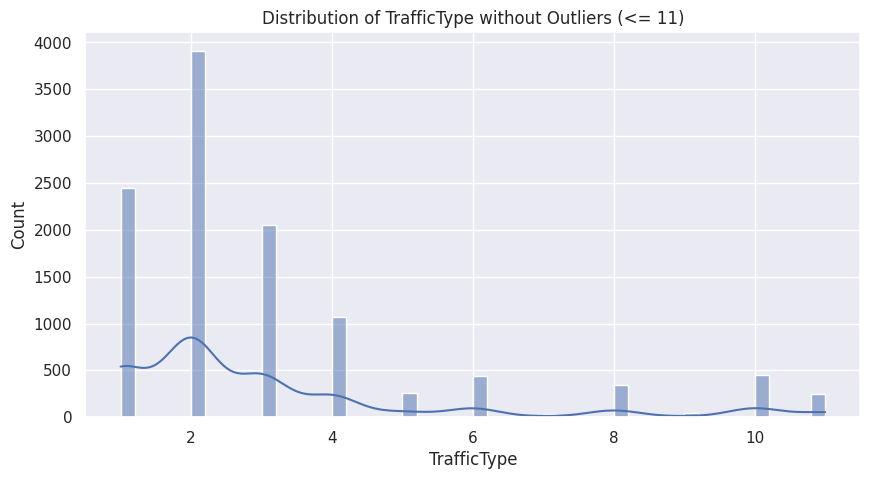

In [2388]:
# Identificarea atributelor numerice
numeric_features = df.select_dtypes(include=[np.number]).columns
for feature in numeric_features:
    # Calculați percentilele cu granularitate de 10%
    percentiles = np.percentile(df[feature], np.arange(0, 101, 10))
    
    # Alegem pragul pentru a elimina outlierii (de exemplu, 90th percentile)
    threshold = percentiles[9]
    
    # Filtrați datele pentru a elimina outlierii
    filtered_data = df[df[feature] <= threshold]
    
    # Realizați un grafic pentru distribuția valorilor fără outlieri
    plt.figure(figsize=(10, 5))
    sns.histplot(filtered_data[feature], bins=50, kde=True)
    
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'Distribution of {feature} without Outliers (<= {int(threshold)})')
    plt.show()

### 2.A Atribute Categorice

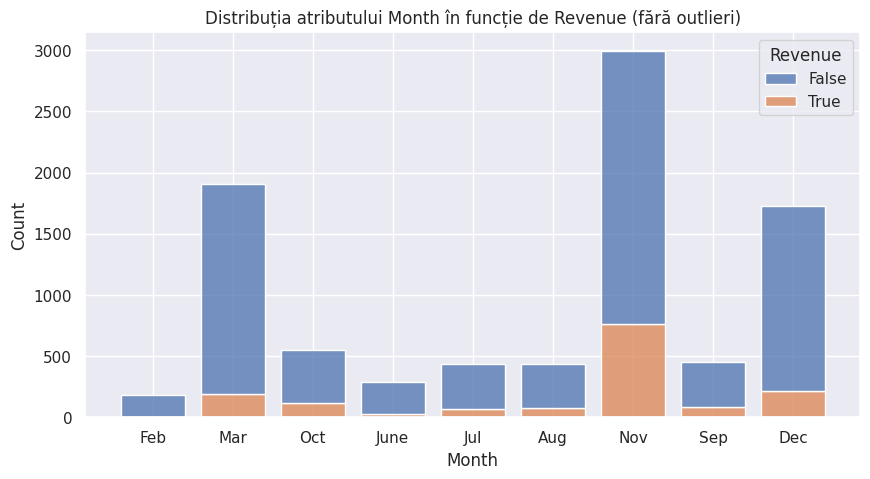

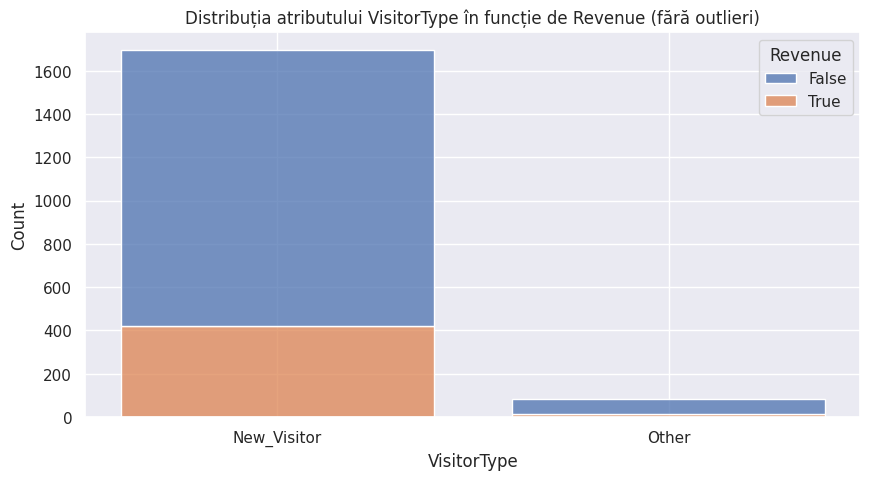

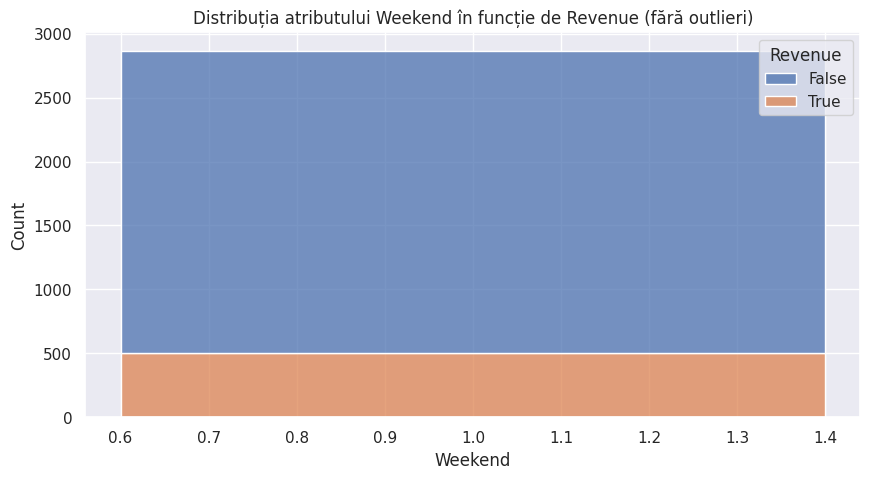

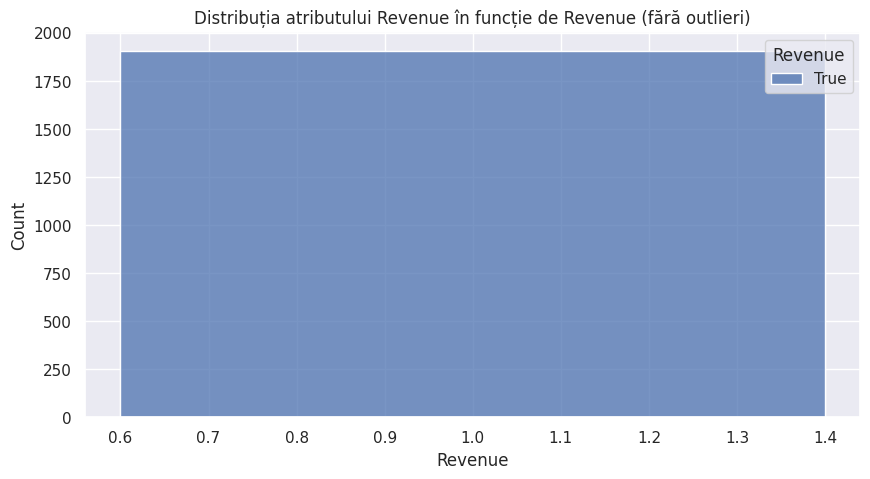

In [2389]:
# Identificarea atributelor categorice
categorical_attributes = df.select_dtypes(exclude=np.number).columns.tolist()

for attribute in categorical_attributes:
    # Calculăm frecvența pentru fiecare categorie
    category_counts = df[attribute].value_counts()

    # Alegem un prag pentru a elimina categoriile cu o frecvență mai mare decât percentilele specificate (de exemplu, 90th percentile)
    threshold = np.percentile(category_counts, 90)

    # Filtrăm datele pentru a păstra doar categoriile cu frecvență sub prag
    df_filtered = df[df[attribute].isin(category_counts[category_counts <= threshold].index)]

    # Realizăm un grafic pentru distribuția categoriilor după eliminarea outlierilor
    plt.figure(figsize=(10, 5))
    sns.histplot(x=attribute, data=df_filtered, hue='Revenue', multiple='stack', shrink=0.8)
    plt.title(f'Distribuția atributului {attribute} în funcție de Revenue (fără outlieri)')
    plt.show()


## 3. Analiza Gradului de Corelare

### 3.A Atribute Numerice cu Coeficientul de Point-Biserial

                  Attribute  Correlation        P-Value
0            Administrative     0.138917   3.519760e-54
1   Administrative_Duration     0.093587   2.146514e-25
2             Informational     0.095200   3.174034e-26
3    Informational_Duration     0.070345   5.282871e-15
4            ProductRelated     0.158538   3.241187e-70
5   ProductRelated_Duration     0.152373   6.115338e-65
6               BounceRates    -0.150673   1.594198e-63
7                 ExitRates    -0.207071  1.662654e-119
8                PageValues     0.492569   0.000000e+00
9                SpecialDay    -0.082305   5.498934e-20
10         OperatingSystems    -0.014668   1.033943e-01
11                  Browser     0.023984   7.736888e-03
12                   Region    -0.011595   1.979426e-01
13              TrafficType    -0.005113   5.702434e-01




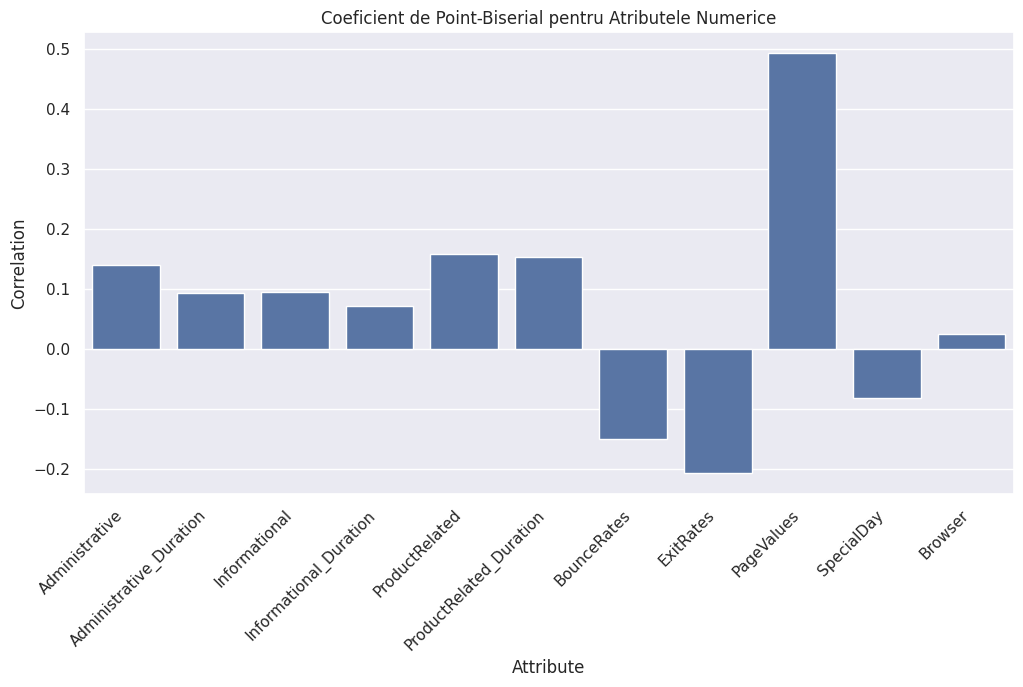

In [2390]:
correlation_results_numeric = []

for attribute in numeric_attributes:
    if attribute != 'Revenue':
        correlation, p_value = pointbiserialr(df[attribute], df['Revenue'])
        correlation_results_numeric.append({'Attribute': attribute, 'Correlation': correlation, 'P-Value': p_value})

# Tabelul cu rezultate
correlation_df_numeric = pd.DataFrame(correlation_results_numeric)
print(correlation_df_numeric)
print('\n')

# Vizualizare pentru atributele cu p-value <= 0.05
significant_numeric_attributes = correlation_df_numeric[correlation_df_numeric['P-Value'] <= 0.05]
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Attribute', y='Correlation', data=significant_numeric_attributes)
plt.title('Coeficient de Point-Biserial pentru Atributele Numerice')

# Rotirea etichetelor pe axa X pentru a face vizualizarea mai lizibilă
X_fields = significant_numeric_attributes['Attribute'].tolist()
barplot.set_xticks(range(len(X_fields)))
barplot.set_xticklabels(X_fields, rotation=45, horizontalalignment='right')

plt.show()

### 3.B Atribute Categorice cu Testul Chi-squared

     Attribute   Chi-squared       P-Value
0        Month    384.934762  2.238786e-77
1  VisitorType    135.251923  4.269904e-30
2      Weekend     10.390978  1.266325e-03
3      Revenue  12322.355847  0.000000e+00




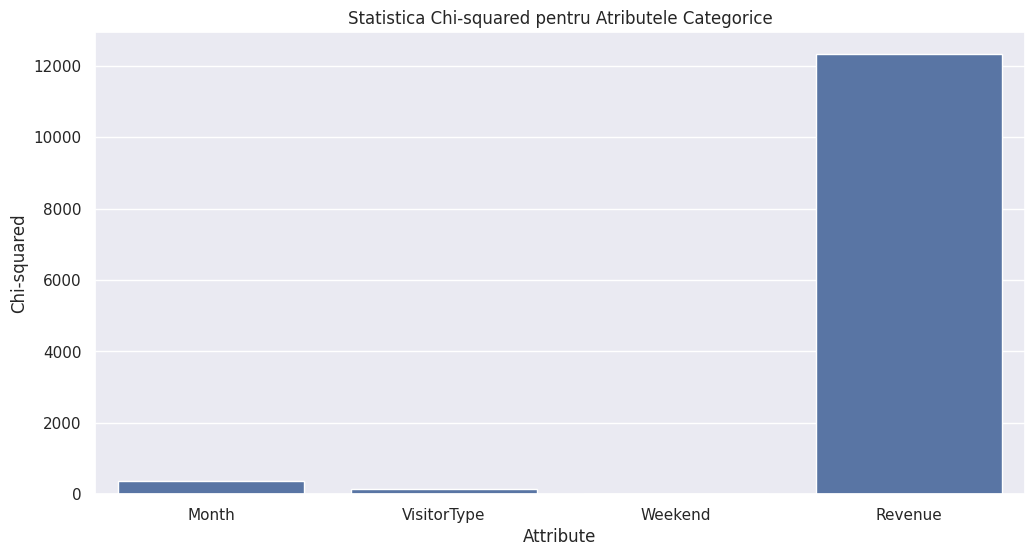

In [2391]:
correlation_results_categorical = []

for attribute in categorical_attributes:
    contingency_table = pd.crosstab(df[attribute], df['Revenue'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    correlation_results_categorical.append({'Attribute': attribute, 'Chi-squared': chi2, 'P-Value': p_value})

# Tabelul cu rezultate
correlation_df_categorical = pd.DataFrame(correlation_results_categorical)
print(correlation_df_categorical)
print('\n')

# Vizualizare pentru atributele cu p-value <= 0.05
significant_categorical_attributes = correlation_df_categorical[correlation_df_categorical['P-Value'] <= 0.05]
plt.figure(figsize=(12, 6))
sns.barplot(x='Attribute', y='Chi-squared', data=significant_categorical_attributes)
plt.title('Statistica Chi-squared pentru Atributele Categorice')
plt.show()


### Concluzia analizei p-value folosind Coeficientul de Point-Biserial si Testul Chi-squared
- Un p-value cat mai mic indica o corelare mai mare a atributului cu tinta de predictie
- Vom folosi p-valiue <= 0.05 ca valoare maxima admisibila pentru un atribut, pentru a-l considera relrevant in predictia noastra

# 3.2. Antrenarea și Evaluarea Algoritmilor de Predicție

#### Setting some variables needed for the comparison

In [2392]:
# Plot X axis step
STEP_PERCENT=1.25
# Number of times to run the function
num_iterations = 10

## 3.2.1. Regresie Logistică

### 1. Implementare manuală

#### Regresia Logistica

In [2393]:
clipped_value = 500

def split_dataset(X, T, train=.8):
    N = X.shape[0]
    N_train = int(round(N * train))
    N_test = N - N_train

    X_train, X_test = X[:N_train, :], X[N_train:, :]
    T_train, T_test = T[:N_train], T[N_train:]
    return X_train, T_train, X_test, T_test

def logistic(x):
    # Clip the input values to prevent overflow
    clipped_x = np.clip(x, -clipped_value, clipped_value)
    
    # Calculate the logistic function on the clipped values
    return 1 / (1 + np.exp(-clipped_x))

# Negative Log Likelihood - functia J(w)
def nll(Y, T):
    epsilon = 1e-15
    Y = np.clip(Y, epsilon, 1 - epsilon)
    return -np.mean(T * np.log(Y) + (1 - T) * np.log(1 - Y))

def accuracy(Y, T):
    predicted_labels = np.round(Y)
    correct_predictions = np.sum(predicted_labels == T)
    total_samples = len(T)
    return correct_predictions / total_samples

# Antrenati modelul logistic (ponderile W), executand epochs_no pasi din algoritmul de gradient descent
def train_logistic(X, T, lr=0.01, epochs_no=100):
    (N, D) = X.shape
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    W = np.random.randn(D + 1)

    for epoch in range(epochs_no):
        Y = logistic(np.dot(X_hat, W))
        gradient = np.dot(X_hat.T, (Y - T))
        W -= lr * gradient

    return W

# Calculati predictia Y a modelului logistic antrenat (ponderile W invatate)
def predict_logistic(X, W):
    X_hat = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    Y = logistic(np.dot(X_hat, W))
    return Y

def train_logistic_full(X, T, lr=0.01, learning_increase_percent=2.5, epochs_no=1000):
    (N, D) = X.shape
    X1 = np.concatenate([np.ones((N, 1)), X], axis=1)
    W = np.random.randn(D + 1)

    X_train, T_train, X_test, T_test = split_dataset(X1, T)
    
    train_acc, test_acc = [], []
    train_nll, test_nll = [], []
    W_trace = [W.copy()]

    for epoch in range(epochs_no):
        # Maresc learning rate-ul pt fiecare epoch
        lr = lr * (1 + learning_increase_percent / 100) 
        
        Y_train = logistic(X_train @ W)
        
        gradient = np.transpose(X_train) @ (Y_train-T_train)/N
        W -= lr * gradient

        logits = np.dot(X_test, W)
        Y_test = 1. / (1. + np.exp(-np.clip(logits, -clipped_value, clipped_value)))

        train_acc.append(accuracy(Y_train, T_train))
        test_acc.append(accuracy(Y_test, T_test))
        train_nll.append(nll(Y_train, T_train))
        test_nll.append(nll(Y_test, T_test))
        W_trace.append(W.copy())

    return W, train_acc, test_acc, train_nll, test_nll, W_trace

#### Preprocesarea datelor

In [2394]:
def preprocess_data(df):
    # Split set de date în caracteristici (X) și variabilă țintă (y)
    X = df.drop('Revenue', axis=1)
    y = df['Revenue'] # Revenue este boolean ( 0 / 1)
    
    # Conversia variabilelor categorice în formă numerică
    label_encoder = LabelEncoder()
    categorical_columns = ['Month', 'VisitorType', 'Weekend']
    for column in categorical_columns:
        X[column] = label_encoder.fit_transform(X[column])

    return X, y

#### Functie pentru plotting

In [2395]:
# Definim o functie ajutatoare pentru plotting
def plot_evolution(train_acc, test_acc, train_nll, test_nll, scaler, step_percent=2.5):
    # Step_percent = 5 <==> 100 / 5 == 20 X points on the plot
    epochs_no = len(train_acc)
    step = round(epochs_no * step_percent / 100)
    # If step is 0, we will set minimum default step for the plotting
    if step == 0:
        step = 1
    fig, (ax1, ax2) = plt.subplots(2, 1)

    # Plotting accuracy evolution
    ax1.plot(range(0, epochs_no, step), train_acc[::step], sns.xkcd_rgb["green"], label="Train Accuracy")
    ax1.plot(range(0, epochs_no, step), test_acc[::step], sns.xkcd_rgb["red"], label="Test Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='lower right', ncol=1)

    # Plotting negative log likelihood evolution
    ax2.plot(range(0, epochs_no, step), train_nll[::step], sns.xkcd_rgb["green"], label="Train NLL")
    ax2.plot(range(0, epochs_no, step), test_nll[::step], sns.xkcd_rgb["red"], label="Test NLL")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("NLL")
    ax2.legend(loc='upper right', ncol=1)

    # Adding title with scaler information
    plt.suptitle(f'Evolution with Scaler: {scaler}')
    plt.show()
    
    return (ax1, ax2)

In [2396]:
# Function to print metrics for a specific measure (e.g., accuracy, precision, recall, f1_score)
def print_metrics(metric_name, results_dict, num_iterations):
    for scaler_name, metric_list in results_dict.items():
        mean_metric = np.mean(metric_list)
        median_metric = np.median(metric_list)
        variance_metric = np.var(metric_list)
        min_metric = np.min(metric_list)
        max_metric = np.max(metric_list)

        print(f"\nMetrics for {metric_name} with {scaler_name} after {num_iterations} runs:")
        print(f"Mean {metric_name}: {mean_metric}")
        print(f"Median {metric_name}: {median_metric}")
        print(f"Variance {metric_name}: {variance_metric}")
        print(f"Min {metric_name}: {min_metric}")
        print(f"Max {metric_name}: {max_metric}")

#### Datele de fitting ale modelului

In [2397]:
EPOCHS_NO = 200
LR = 0.035
LEARNING_INCREASE_PERCENT = 1

### Scalers

In [2398]:
# Normalizarea datelor (Scalare)
scalers = {
        'MinMaxScaler': MinMaxScaler(),
        'StandardScaler': StandardScaler(),
        'RobustScaler': RobustScaler()
}

In [2399]:
def logistic_regression_manual(X, y, lr=0.01, learning_increase_percent=2.5, epochs_no=100, step_percent=100):
    # Modify the dataset to include only the features we consider relevant to our target
    # Lista cu numele caracteristicilor selectate pe baza p-value-ului
    selected_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                     'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
                     'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Month', 'VisitorType', 'Weekend']
    X_selected = X[selected_features]
    
    # Iterate over the scalers
    for scaler_name, scaler in scalers.items():
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        # Scalarea datelor de antrenare
        X_train_scaled = scaler.fit_transform(X_train)

        # Antrenarea modelului logistic
        W, train_acc, test_acc, train_nll, test_nll, W_trace = train_logistic_full(X_train_scaled, y_train, lr=lr, epochs_no=epochs_no)

        # Evaluarea modelului pe setul de testare
        X_test_scaled = scaler.transform(X_test)
        Y_test = predict_logistic(X_test_scaled, W)

        # Evaluare metrici pe setul de testare
        precision = precision_score(y_test, np.round(Y_test))
        recall = recall_score(y_test, np.round(Y_test))
        f1 = f1_score(y_test, np.round(Y_test))
        test_accuracy = accuracy(Y_test, y_test)

        # Afișare și salvare metrici
        print(f"Acuratete folosind {scaler_name}: {test_accuracy}")
        print(f"Precision folosind {scaler_name}: {precision}")
        print(f"Recall folosind {scaler_name}: {recall}")
        print(f"F1 Score folosind {scaler_name}: {f1}")
        
        # Save metric values in dictionaries
        if scaler_name not in precision_results:
            precision_results[scaler_name] = []
        precision_results[scaler_name].append(precision)
        if scaler_name not in recall_results:
            recall_results[scaler_name] = []
        recall_results[scaler_name].append(recall)
        if scaler_name not in f1_score_results:
            f1_score_results[scaler_name] = []
        f1_score_results[scaler_name].append(f1)
        if scaler_name not in accuracy_results:
            accuracy_results[scaler_name] = []
        accuracy_results[scaler_name].append(test_accuracy)

        # Vizualizare evolutie
        plot_evolution(train_acc, test_acc, train_nll, test_nll, scaler, step_percent)
        
        # Eliberare memorie
        del X_train, X_train_scaled, X_test_scaled, Y_test, W, train_acc, test_acc, train_nll, test_nll, W_trace

#### Rulam de 10 ori algoritmul pe sample-uri random ale datasetului initial

Training dataset size: 12330
Number of features: 17

RULAREA NUMARUL 1
Acuratete folosind MinMaxScaler: 0.7785888077858881
Precision folosind MinMaxScaler: 0.005988023952095809
Recall folosind MinMaxScaler: 0.0026246719160104987
F1 Score folosind MinMaxScaler: 0.0036496350364963507


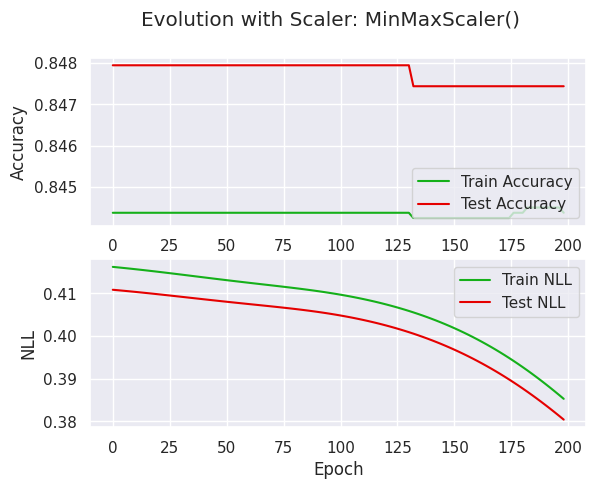

Acuratete folosind StandardScaler: 0.32116788321167883
Precision folosind StandardScaler: 0.06225165562913907
Recall folosind StandardScaler: 0.26704545454545453
F1 Score folosind StandardScaler: 0.10096670247046187


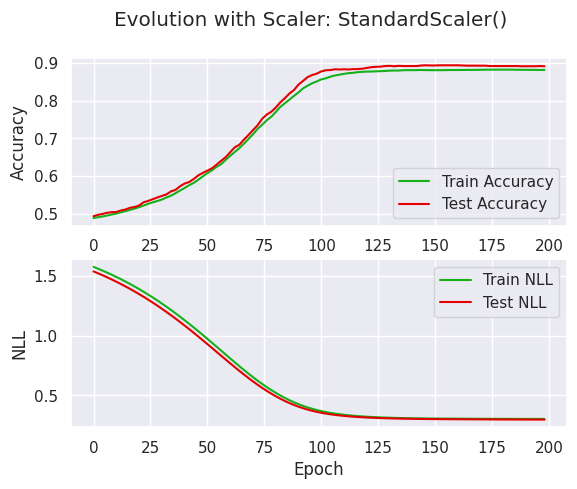

Acuratete folosind RobustScaler: 0.727088402270884
Precision folosind RobustScaler: 0.0220125786163522
Recall folosind RobustScaler: 0.018970189701897018
F1 Score folosind RobustScaler: 0.020378457059679764


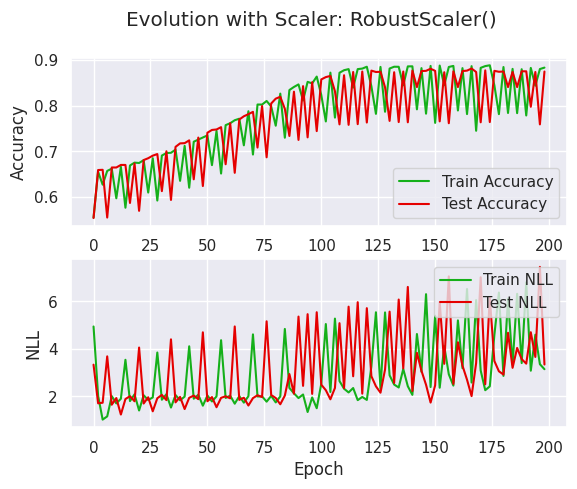


RULAREA NUMARUL 2
Acuratete folosind MinMaxScaler: 0.748580697485807
Precision folosind MinMaxScaler: 0.15960912052117263
Recall folosind MinMaxScaler: 0.1192214111922141
F1 Score folosind MinMaxScaler: 0.13649025069637882


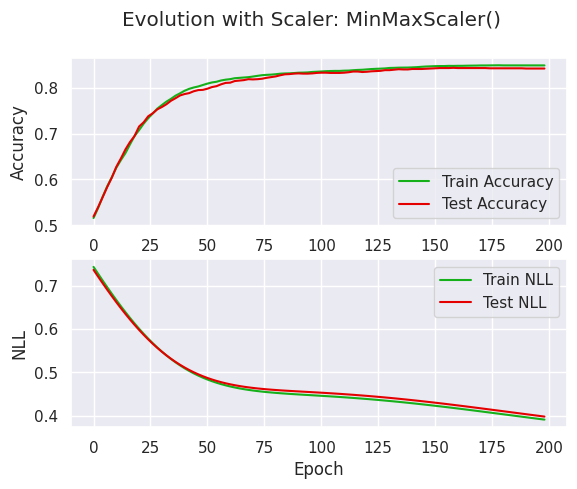

Acuratete folosind StandardScaler: 0.4124087591240876
Precision folosind StandardScaler: 0.11777003484320557
Recall folosind StandardScaler: 0.48011363636363635
F1 Score folosind StandardScaler: 0.18914381645215445


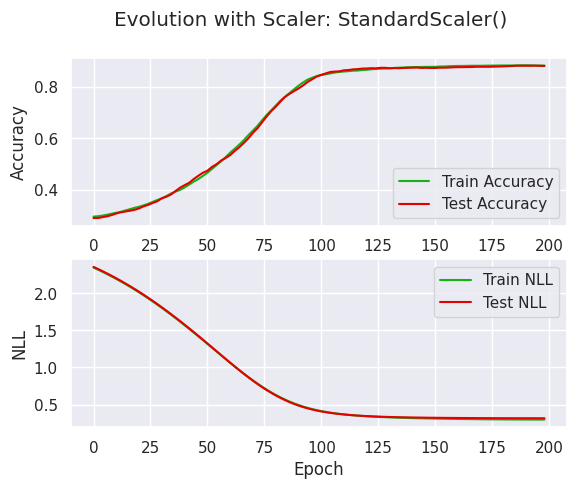

Acuratete folosind RobustScaler: 0.46634225466342255
Precision folosind RobustScaler: 0.03282051282051282
Recall folosind RobustScaler: 0.07901234567901234
F1 Score folosind RobustScaler: 0.04637681159420289


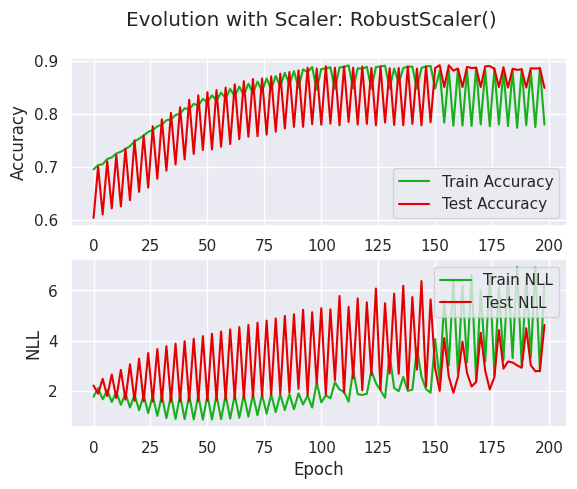


RULAREA NUMARUL 3
Acuratete folosind MinMaxScaler: 0.8081914030819141
Precision folosind MinMaxScaler: 0.19491525423728814
Recall folosind MinMaxScaler: 0.057356608478802994
F1 Score folosind MinMaxScaler: 0.08863198458574181


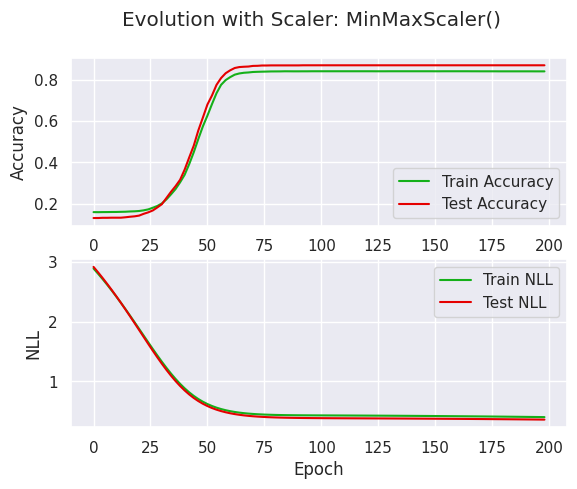

Acuratete folosind StandardScaler: 0.38077858880778587
Precision folosind StandardScaler: 0.0986703988803359
Recall folosind StandardScaler: 0.37105263157894736
F1 Score folosind StandardScaler: 0.15588723051409617


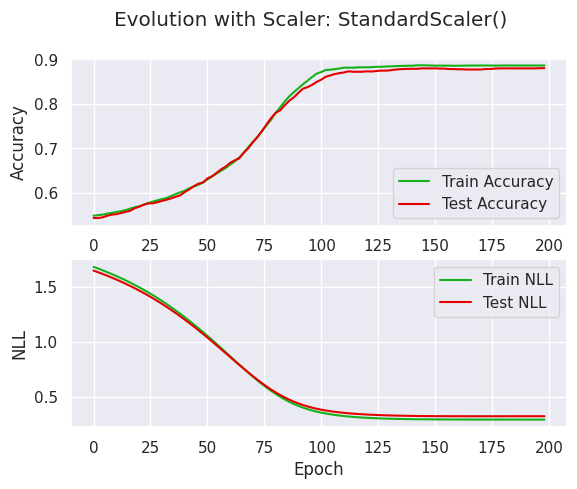

Acuratete folosind RobustScaler: 0.44768856447688565
Precision folosind RobustScaler: 0.04277566539923954
Recall folosind RobustScaler: 0.1125
F1 Score folosind RobustScaler: 0.06198347107438016


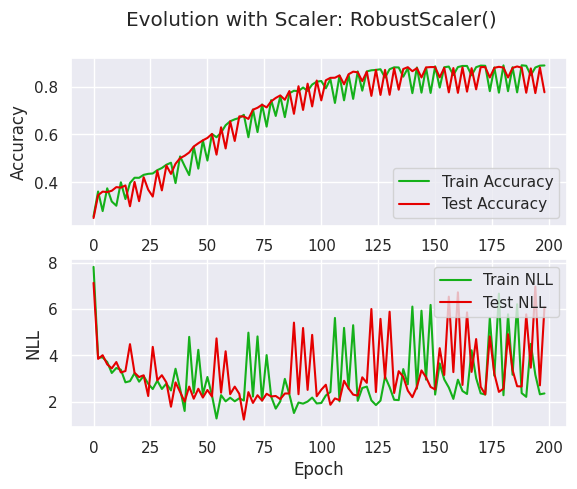


RULAREA NUMARUL 4
Acuratete folosind MinMaxScaler: 0.2704785077047851
Precision folosind MinMaxScaler: 0.14753272910372608
Recall folosind MinMaxScaler: 0.7343358395989975
F1 Score folosind MinMaxScaler: 0.2457023060796646


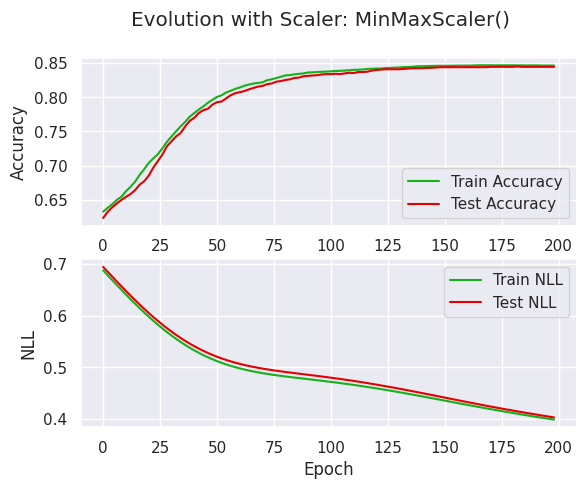

Acuratete folosind StandardScaler: 0.34590429845904297
Precision folosind StandardScaler: 0.0883940620782726
Recall folosind StandardScaler: 0.3333333333333333
F1 Score folosind StandardScaler: 0.13973333333333335


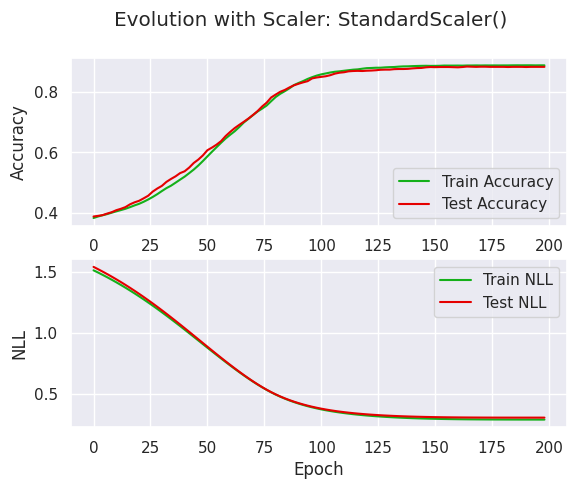

Acuratete folosind RobustScaler: 0.6224655312246553
Precision folosind RobustScaler: 0.05
Recall folosind RobustScaler: 0.08310991957104558
F1 Score folosind RobustScaler: 0.062437059415911385


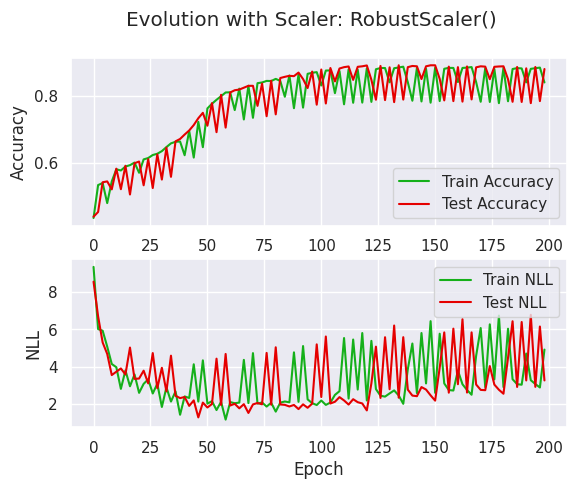


RULAREA NUMARUL 5
Acuratete folosind MinMaxScaler: 0.30940794809407945
Precision folosind MinMaxScaler: 0.13009049773755657
Recall folosind MinMaxScaler: 0.5822784810126582
F1 Score folosind MinMaxScaler: 0.21266759130836801


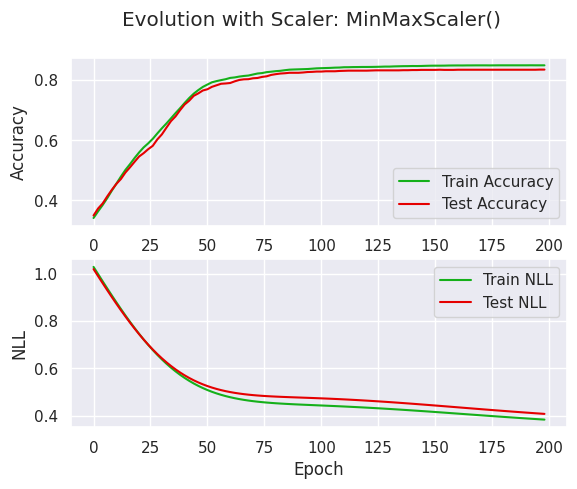

Acuratete folosind StandardScaler: 0.32441200324412
Precision folosind StandardScaler: 0.05449591280653951
Recall folosind StandardScaler: 0.22346368715083798
F1 Score folosind StandardScaler: 0.08762322015334062


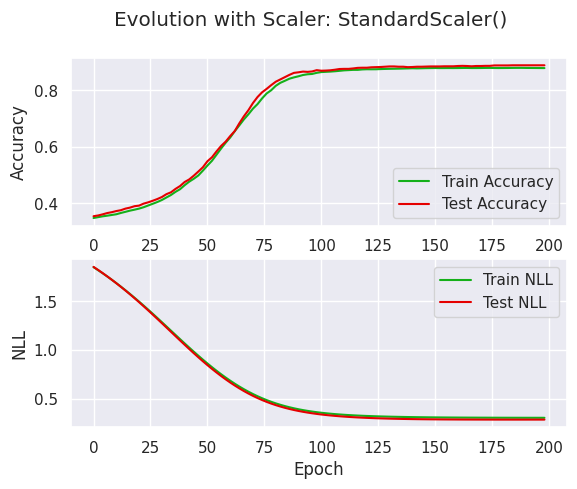

Acuratete folosind RobustScaler: 0.46553122465531227
Precision folosind RobustScaler: 0.029175050301810865
Recall folosind RobustScaler: 0.07591623036649214
F1 Score folosind RobustScaler: 0.04215116279069767


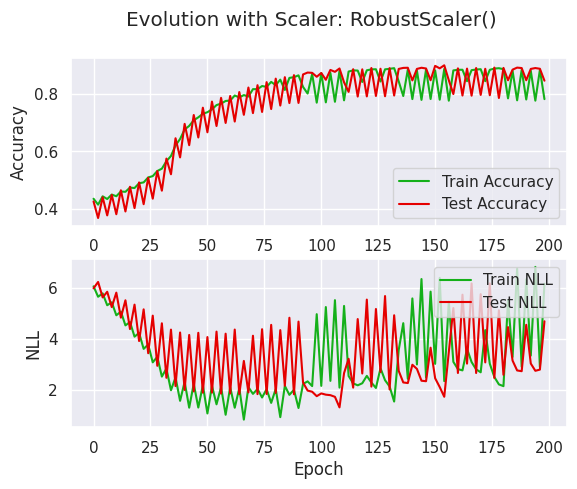


RULAREA NUMARUL 6
Acuratete folosind MinMaxScaler: 0.7380373073803731
Precision folosind MinMaxScaler: 0.026923076923076925
Recall folosind MinMaxScaler: 0.0175
F1 Score folosind MinMaxScaler: 0.021212121212121213


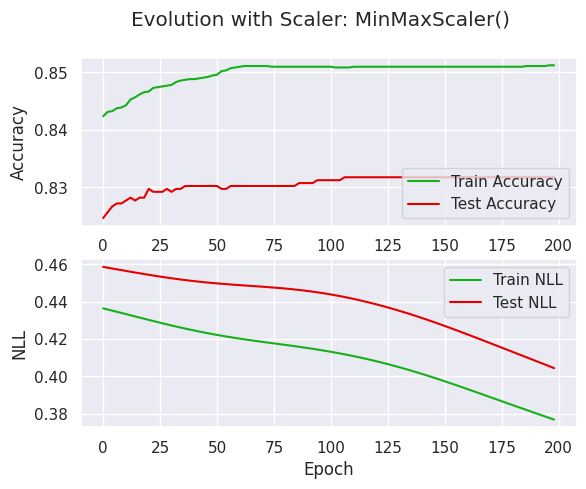

Acuratete folosind StandardScaler: 0.35279805352798055
Precision folosind StandardScaler: 0.09805238415043653
Recall folosind StandardScaler: 0.3659147869674185
F1 Score folosind StandardScaler: 0.15466101694915252


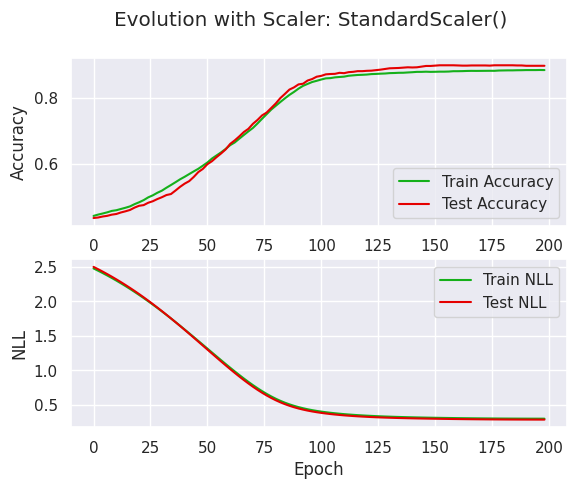

Acuratete folosind RobustScaler: 0.47364152473641524
Precision folosind RobustScaler: 0.04500978473581213
Recall folosind RobustScaler: 0.125
F1 Score folosind RobustScaler: 0.06618705035971223


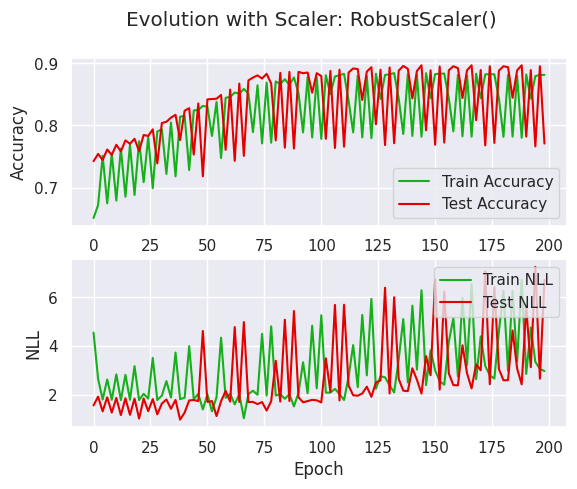


RULAREA NUMARUL 7
Acuratete folosind MinMaxScaler: 0.7935928629359287
Precision folosind MinMaxScaler: 0.14705882352941177
Recall folosind MinMaxScaler: 0.06426735218508997
F1 Score folosind MinMaxScaler: 0.08944543828264759


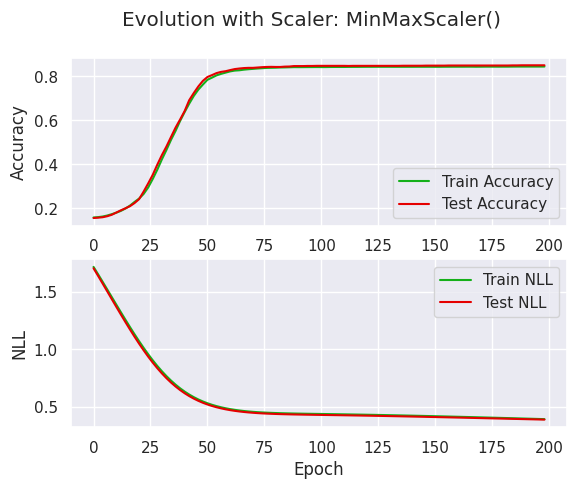

Acuratete folosind StandardScaler: 0.33901054339010545
Precision folosind StandardScaler: 0.08202323991797676
Recall folosind StandardScaler: 0.29484029484029484
F1 Score folosind StandardScaler: 0.1283422459893048


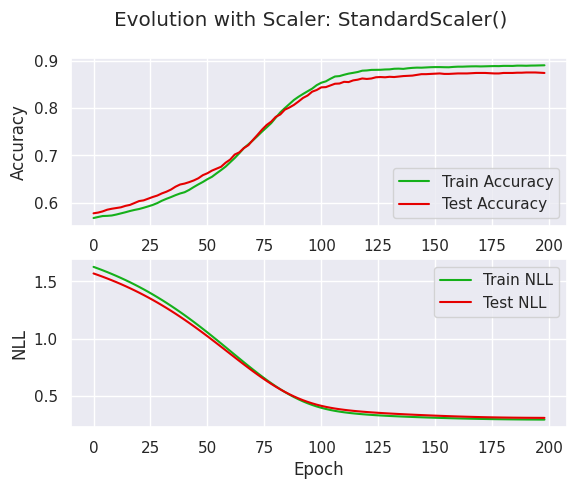

Acuratete folosind RobustScaler: 0.5896188158961881
Precision folosind RobustScaler: 0.13856812933025403
Recall folosind RobustScaler: 0.31088082901554404
F1 Score folosind RobustScaler: 0.19169329073482427


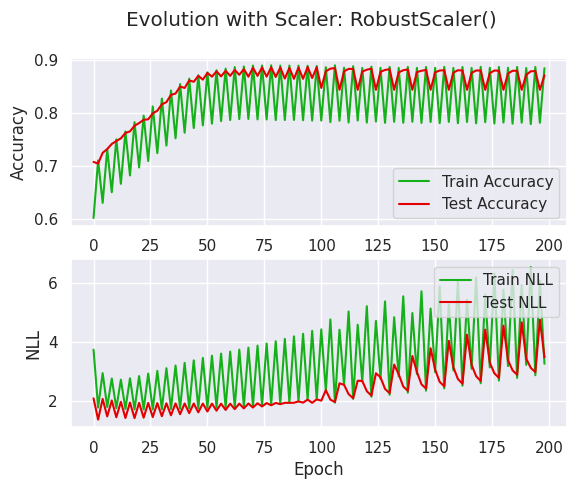


RULAREA NUMARUL 8
Acuratete folosind MinMaxScaler: 0.7712895377128953
Precision folosind MinMaxScaler: 0.1341991341991342
Recall folosind MinMaxScaler: 0.07848101265822785
F1 Score folosind MinMaxScaler: 0.09904153354632589


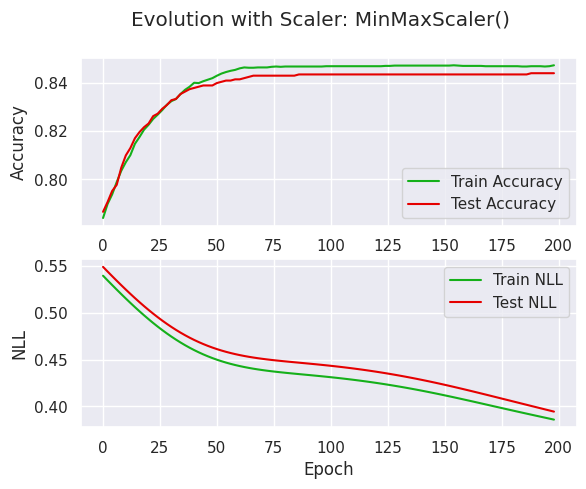

Acuratete folosind StandardScaler: 0.321573398215734
Precision folosind StandardScaler: 0.07526178010471204
Recall folosind StandardScaler: 0.30666666666666664
F1 Score folosind StandardScaler: 0.12086179716237519


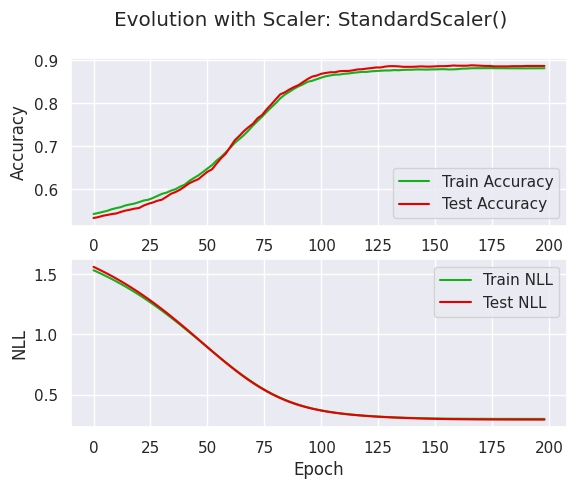

Acuratete folosind RobustScaler: 0.483779399837794
Precision folosind RobustScaler: 0.03979591836734694
Recall folosind RobustScaler: 0.10512129380053908
F1 Score folosind RobustScaler: 0.05773501110288675


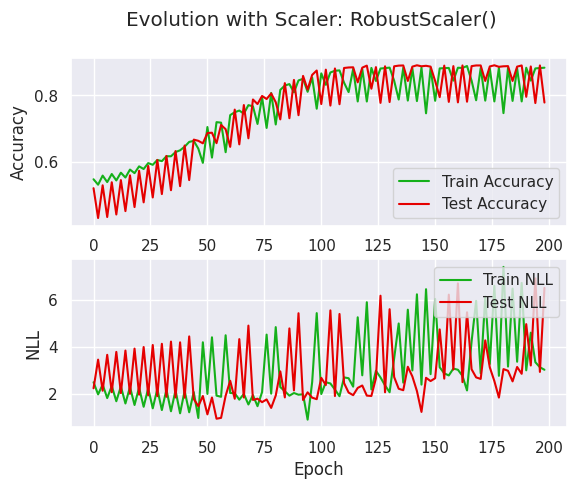


RULAREA NUMARUL 9
Acuratete folosind MinMaxScaler: 0.7327656123276561
Precision folosind MinMaxScaler: 0.12179487179487179
Recall folosind MinMaxScaler: 0.08983451536643026
F1 Score folosind MinMaxScaler: 0.1034013605442177


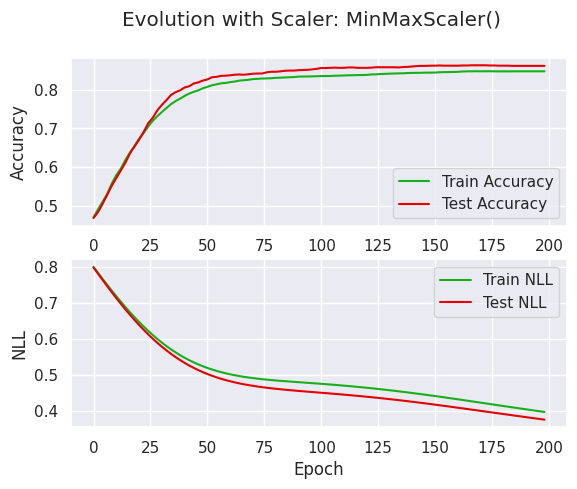

Acuratete folosind StandardScaler: 0.3471208434712084
Precision folosind StandardScaler: 0.08671713695801789
Recall folosind StandardScaler: 0.3080684596577017
F1 Score folosind StandardScaler: 0.13533834586466167


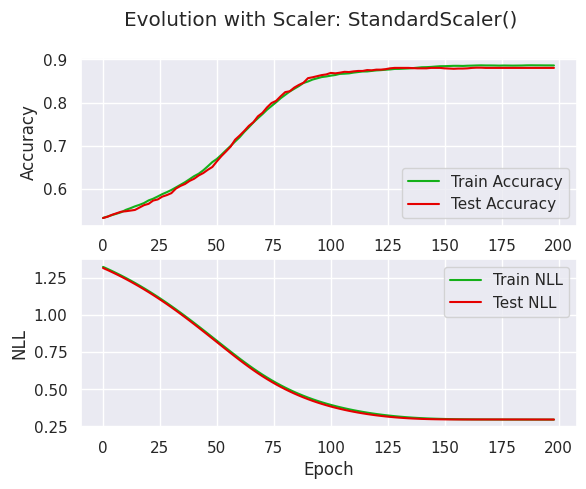

Acuratete folosind RobustScaler: 0.4651257096512571
Precision folosind RobustScaler: 0.035053554040895815
Recall folosind RobustScaler: 0.0989010989010989
F1 Score folosind RobustScaler: 0.05176132278936017


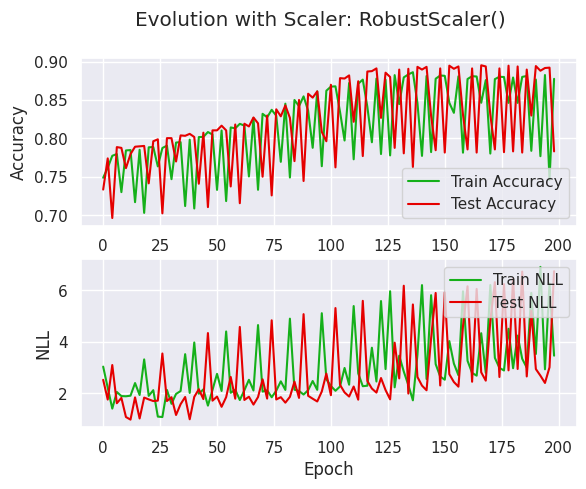


RULAREA NUMARUL 10
Acuratete folosind MinMaxScaler: 0.7465531224655312
Precision folosind MinMaxScaler: 0.1373134328358209
Recall folosind MinMaxScaler: 0.12041884816753927
F1 Score folosind MinMaxScaler: 0.12831241283124128


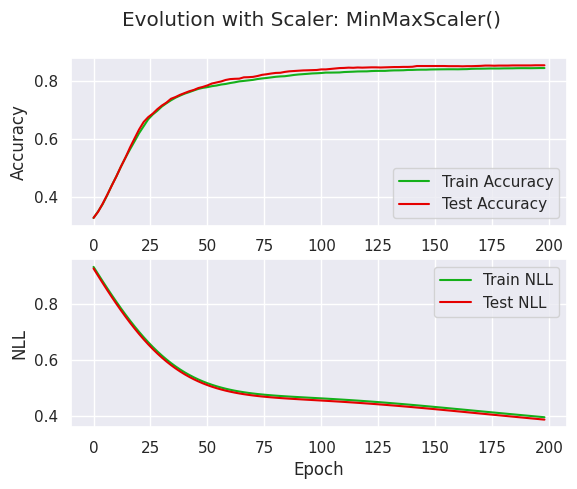

Acuratete folosind StandardScaler: 0.370235198702352
Precision folosind StandardScaler: 0.08391608391608392
Recall folosind StandardScaler: 0.3305785123966942
F1 Score folosind StandardScaler: 0.13385387618516453


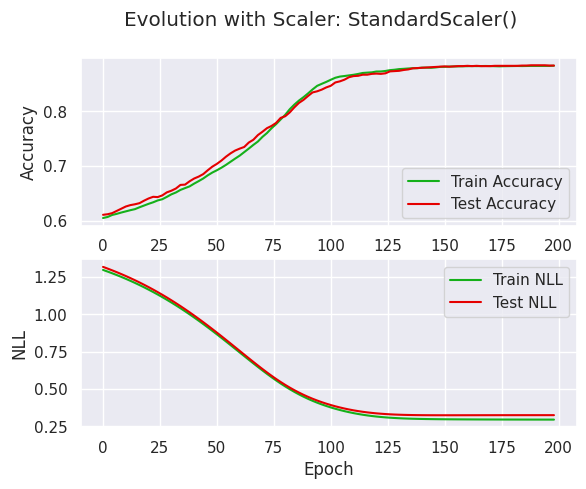

Acuratete folosind RobustScaler: 0.5032441200324412
Precision folosind RobustScaler: 0.022573363431151242
Recall folosind RobustScaler: 0.052770448548812667
F1 Score folosind RobustScaler: 0.03162055335968379


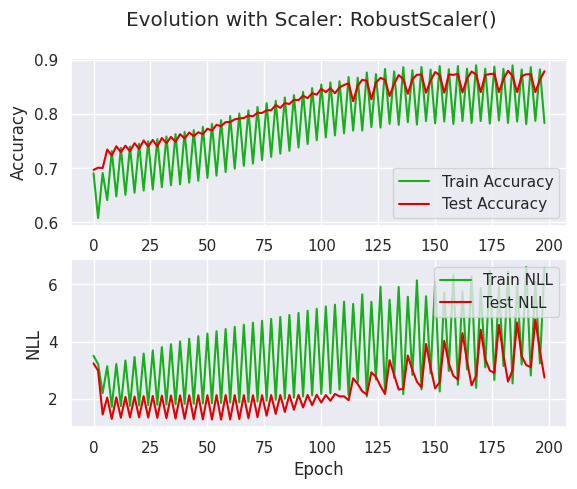

In [2400]:
# Print information about the training dataset
(N, D) = df.shape
print(f"Training dataset size: {N}")
print(f"Number of features: {D - 1}")

# Create dictionaries to store metric values
precision_results = {}
recall_results = {}
f1_score_results = {}
accuracy_results = {}

for iteration in range(num_iterations):
    # Amestecarea (randomizarea) rândurilor
    df = df.sample(frac=1).reset_index(drop=True)
    # Preprocesarea datelor
    X, y = preprocess_data(df.copy())

    print(f"\nRULAREA NUMARUL {iteration + 1}")
    # Apelul funcției cu datele specifice
    logistic_regression_manual(X,y,lr=LR,learning_increase_percent=LEARNING_INCREASE_PERCENT,epochs_no=EPOCHS_NO,step_percent=STEP_PERCENT)
    del X, y

#### Conclusion for the manual logistic regression

In [2401]:
print("\nFINAL STATISTICS")
# Print accuracy metrics
print("\nACCURACY")
print_metrics("Accuracy", accuracy_results, num_iterations)
# Print precision metrics
print("\nPRECISION")
print_metrics("Precision", precision_results, num_iterations)
# Print recall metrics
print("\nRECALL")
print_metrics("Recall", recall_results, num_iterations)
# Print F1 score metrics
print("\nF1")
print_metrics("F1 Score", f1_score_results, num_iterations)

del precision_results, recall_results, f1_score_results, accuracy_results


FINAL STATISTICS

ACCURACY

Metrics for Accuracy with MinMaxScaler after 10 runs:
Mean Accuracy: 0.6697485806974858
Median Accuracy: 0.7475669099756691
Variance Accuracy: 0.03666704817307762
Min Accuracy: 0.2704785077047851
Max Accuracy: 0.8081914030819141

Metrics for Accuracy with StandardScaler after 10 runs:
Mean Accuracy: 0.35154095701540955
Median Accuracy: 0.34651257096512567
Variance Accuracy: 0.0007675662324729049
Min Accuracy: 0.32116788321167883
Max Accuracy: 0.4124087591240876

Metrics for Accuracy with RobustScaler after 10 runs:
Mean Accuracy: 0.5244525547445256
Median Accuracy: 0.4787104622871046
Variance Accuracy: 0.00758612507227244
Min Accuracy: 0.44768856447688565
Max Accuracy: 0.727088402270884

PRECISION

Metrics for Precision with MinMaxScaler after 10 runs:
Mean Precision: 0.12054249648341549
Median Precision: 0.13575628351747754
Variance Precision: 0.003093692019398062
Min Precision: 0.005988023952095809
Max Precision: 0.19491525423728814

Metrics for Precision

### 2. Implementare folosind scikit-learn

In [2402]:
def logistic_regression_scikit_learn(X, y, step_percent=100):
    # Iterate over the scalers
    for scaler_name, scaler in scalers.items():
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        # Scalarea datelor de antrenare
        X_train_scaled = scaler.fit_transform(X_train)
    
        # Create and train the logistic regression model
        model = LogisticRegression(random_state=None, max_iter=5000)
        model.fit(X_train_scaled, y_train)

        # Make predictions on the test set
        X_test_scaled = scaler.transform(X_test)
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate the model
        test_accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Afișare și salvare metrici
        print(f"Acuratete folosind {scaler_name}: {test_accuracy}")
        print(f"Precision folosind {scaler_name}: {precision}")
        print(f"Recall folosind {scaler_name}: {recall}")
        print(f"F1 Score folosind {scaler_name}: {f1}")
        
        # Save metric values in dictionaries
        if scaler_name not in precision_results:
            precision_results[scaler_name] = []
        precision_results[scaler_name].append(precision)
        if scaler_name not in recall_results:
            recall_results[scaler_name] = []
        recall_results[scaler_name].append(recall)
        if scaler_name not in f1_score_results:
            f1_score_results[scaler_name] = []
        f1_score_results[scaler_name].append(f1)
        if scaler_name not in accuracy_results:
            accuracy_results[scaler_name] = []
        accuracy_results[scaler_name].append(test_accuracy)

        # Clean up variables
        del model

    # Clean up remaining variables
    del X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled

#### Rulam de 10 ori algoritmul pe sample-uri random ale datasetului initial

In [2403]:
# Print information about the training dataset
(N, D) = df.shape
print(f"Training dataset size: {N}")
print(f"Number of features: {D - 1}")

# Create dictionaries to store metric values
precision_results = {}
recall_results = {}
f1_score_results = {}
accuracy_results = {}

for iteration in range(num_iterations):
    # Amestecarea (randomizarea) rândurilor
    df = df.sample(frac=1).reset_index(drop=True)
    X, y = preprocess_data(df.copy())

    print(f"\nRUN NUMBER {iteration + 1}")
    # Apelul funcției cu datele specifice
    logistic_regression_scikit_learn(X, y, step_percent=STEP_PERCENT)
    del X, y

Training dataset size: 12330
Number of features: 17

RUN NUMBER 1
Acuratete folosind MinMaxScaler: 0.8613138686131386
Precision folosind MinMaxScaler: 0.7846153846153846
Recall folosind MinMaxScaler: 0.24519230769230768
F1 Score folosind MinMaxScaler: 0.37362637362637363
Acuratete folosind StandardScaler: 0.8832116788321168
Precision folosind StandardScaler: 0.823170731707317
Recall folosind StandardScaler: 0.3426395939086294
F1 Score folosind StandardScaler: 0.48387096774193544
Acuratete folosind RobustScaler: 0.8852392538523925
Precision folosind RobustScaler: 0.776595744680851
Recall folosind RobustScaler: 0.3772609819121447
F1 Score folosind RobustScaler: 0.5078260869565216

RUN NUMBER 2
Acuratete folosind MinMaxScaler: 0.8803730738037308
Precision folosind MinMaxScaler: 0.7841726618705036
Recall folosind MinMaxScaler: 0.2914438502673797
F1 Score folosind MinMaxScaler: 0.4249512670565302
Acuratete folosind StandardScaler: 0.884022708840227
Precision folosind StandardScaler: 0.76666

#### Conclusion for the scikit-learn logistic regression

In [2404]:
print("\nFINAL STATISTICS")
# Print accuracy metrics
print("\nACCURACY")
print_metrics("Accuracy", accuracy_results, num_iterations)
# Print precision metrics
print("\nPRECISION")
print_metrics("Precision", precision_results, num_iterations)
# Print recall metrics
print("\nRECALL")
print_metrics("Recall", recall_results, num_iterations)
# Print F1 score metrics
print("\nF1")
print_metrics("F1 Score", f1_score_results, num_iterations)

# Clean up remaining variables
del precision_results, recall_results, f1_score_results, accuracy_results


FINAL STATISTICS

ACCURACY

Metrics for Accuracy with MinMaxScaler after 10 runs:
Mean Accuracy: 0.8717356042173561
Median Accuracy: 0.8722627737226277
Variance Accuracy: 3.2725685708441e-05
Min Accuracy: 0.8613138686131386
Max Accuracy: 0.8803730738037308

Metrics for Accuracy with StandardScaler after 10 runs:
Mean Accuracy: 0.882441200324412
Median Accuracy: 0.8836171938361719
Variance Accuracy: 2.7772680062803852e-05
Min Accuracy: 0.875506893755069
Max Accuracy: 0.8909164639091647

Metrics for Accuracy with RobustScaler after 10 runs:
Mean Accuracy: 0.8830089213300892
Median Accuracy: 0.8832116788321168
Variance Accuracy: 2.3622153419514294e-05
Min Accuracy: 0.8746958637469586
Max Accuracy: 0.8901054339010543

PRECISION

Metrics for Precision with MinMaxScaler after 10 runs:
Mean Precision: 0.7695109164262786
Median Precision: 0.7740447957839263
Variance Precision: 0.0008370213492000126
Min Precision: 0.7142857142857143
Max Precision: 0.819672131147541

Metrics for Precision with 

## 3.2.2. Arbore de Decizie

### 1. Implementare folosind scikit-learn

### 2. Implementare manuală